In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import numpy as np
from viz import plot_opinions_over_time, plot_campaign_budgets_with_order
from algos import compute_expected_value_for_budget_distribution, dynamic_programming_with_grid, forward_propagation_with_grid  
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from algos import *

In [17]:
def create_adjacency_matrix_from_links(num_nodes, links):
    adjacency_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    for link in links:
        from_node, to_node = link
        # adjacency_matrix[from_node, to_node] = 1
        adjacency_matrix[to_node, from_node] = 1

    return adjacency_matrix


def init_env():
    links = [
        (0, 2),
        (0, 4),
        (0, 5),
        (0, 6),
        (1, 3),
        (1, 8),
        (2, 0),
        (2, 1),
        (3, 0),
        (4, 0),
        (4, 5),
        (5, 4),
        (5, 10),
        (6, 4),
        (6, 9),
        (6, 11),
        (7, 5),
        (7, 8),
        (8, 1),
        (8, 5),
        (9, 6),
        (9, 12),
        (10, 5),
        (10, 7),
        (10, 13),
        (11, 5),
        (11, 6),
        (11, 7),
        (11, 14),
        (12, 8),
        (13, 5),
        (13, 11),
        (14, 5),
        (14, 11),
    ]

    num_nodes = 15
    connectivity_matrix = create_adjacency_matrix_from_links(num_nodes, links)
    # connectivity_matrix = normalize_adjacency_matrix(connectivity_matrix)

    initial_opinions = np.linspace(0, 1, num_nodes)
    # initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1

    env = NetworkGraph(
        connectivity_matrix=connectivity_matrix,
        initial_opinions=initial_opinions,
        max_u=0.2,
        budget=100.0,
        desired_opinion=1.0,
        tau=0.5,
        max_steps=1_000_000,
    )

    env.reset()

    return env

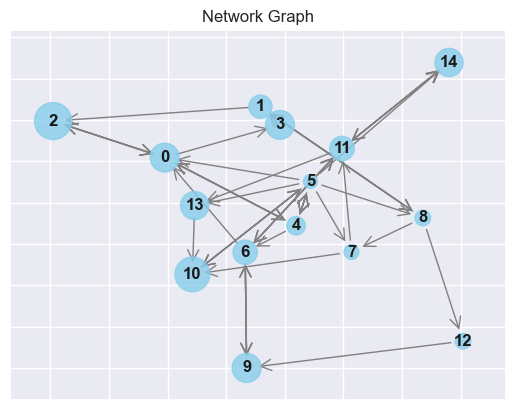

In [18]:
env = init_env()
env.render(mode="matplotlib")

c:\Users\Chainsword\anaconda3\envs\phd_rl_algos\Lib\site-packages\rl_envs_forge\envs\network_graph\visualize.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_labels, y=sorted_centralities, palette="Blues_d")


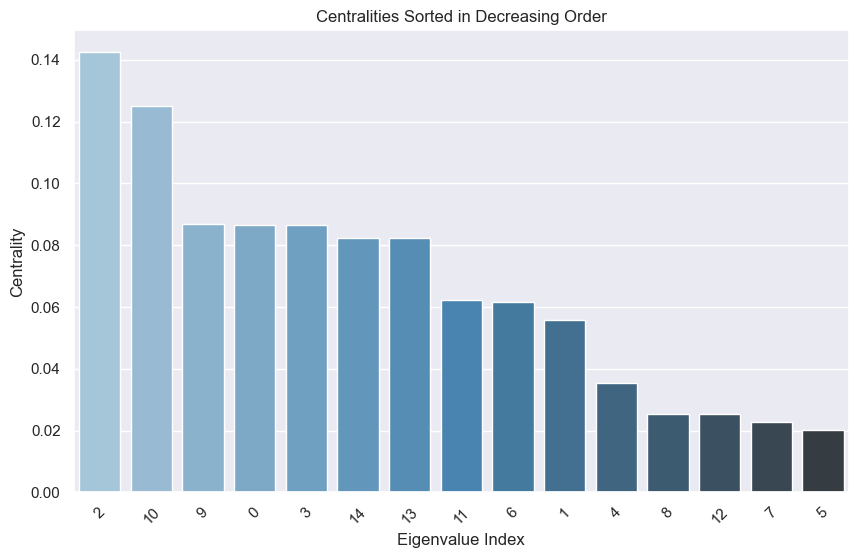

In [19]:
env.render(mode="centralities")

## Zero control 

Overall Error: 0.5079612001655786
Final Error: 0.5134870962840572


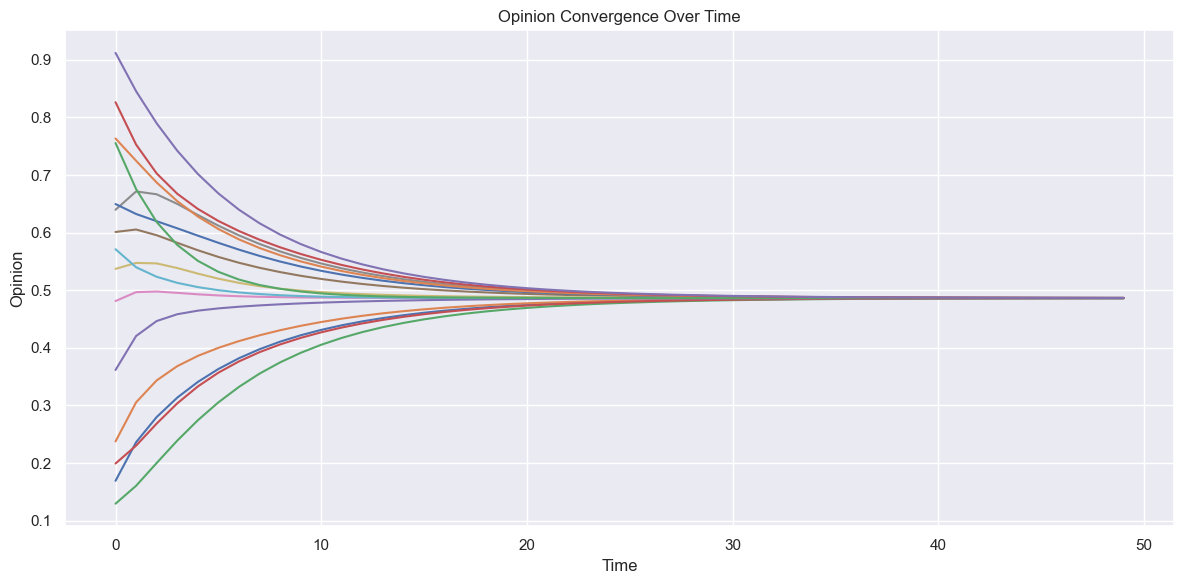

In [20]:
# Define the number of steps for which to apply the zero control input
env = init_env()

num_steps = 50

# Initialize an array to store opinions over time
opinions_over_time = np.zeros((num_steps, env.num_agents))

# Run the simulation with zero control input
for i in range(num_steps):
    no_action_u = np.zeros(env.num_agents)  # Zero control input
    opinions, reward, done, truncated, info = env.step(no_action_u)
    opinions_over_time[i] = opinions


overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

## Broadcast Strategy (use all available budget at start)

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.4081531665919183
Final Error: 0.4107871997906066


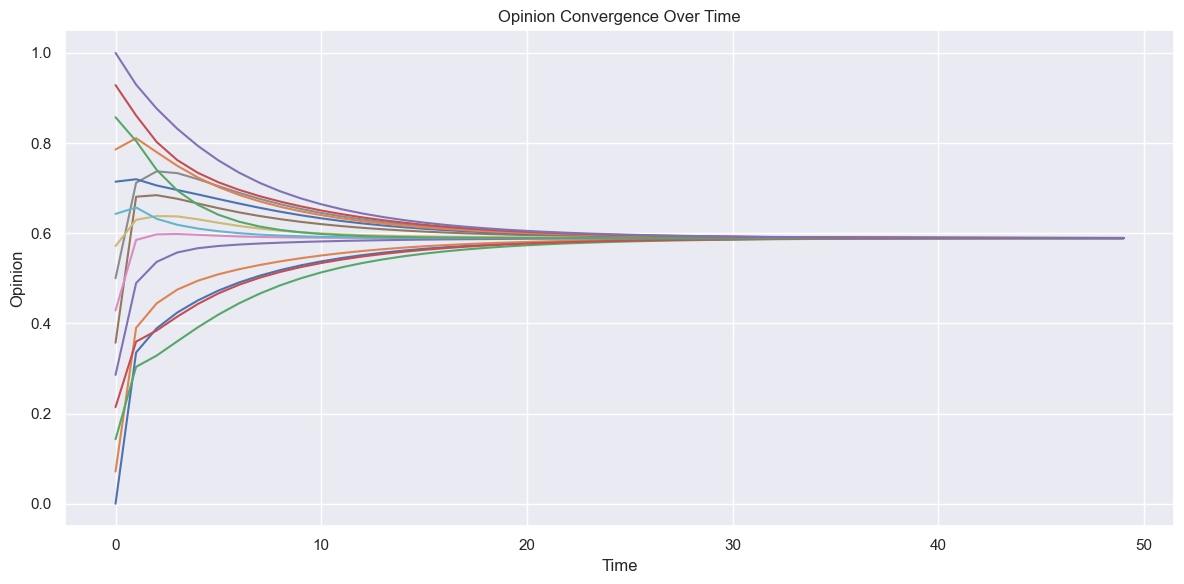

In [21]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

# Run the experiment with the broadcast strategy
opinions_over_time_broadcast, budget_distribution, affected_nodes = (
    run_broadcast_strategy(env, Q, num_steps)
)
overall_error_broadcast = compute_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)
final_error_broadcast = compute_final_average_error(
    opinions_over_time_broadcast, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time_broadcast)

### Broadcast with single step

[0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2]
Broadcast Strategy - Overall Error: 0.45539483851362145
Final Error: 0.41078967702724306


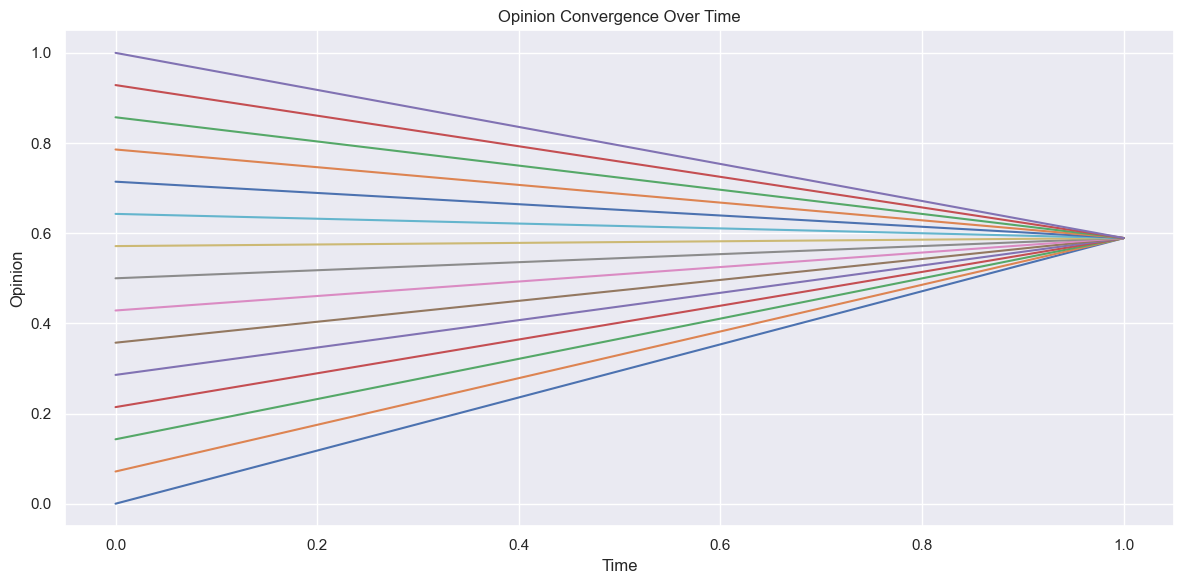

In [22]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation
Q = 15  # Total budget

opinions_over_time = np.zeros((2, env.num_agents))

# Lists to store budget distribution and affected nodes
budget_distribution = []
affected_nodes = []

# Store opinions before applying the first control step
opinions_over_time[0] = env.opinions.copy()

# Calculate the control action using the total budget (units of u_max)
optimal_action, remaining_budget, controlled_agents = optimal_control_action(env, Q)
print(optimal_action)

# Apply the control for the first step
opinions, reward, done, truncated, info = env.step(
    optimal_action, step_duration=0.5 * num_steps
)
opinions_over_time[1] = opinions

# Track affected nodes and budget
affected_nodes.append(list(np.where(optimal_action > 0)[0]))
budget_distribution.append(np.sum(optimal_action))  # Budget used in the first step

overall_error_broadcast = compute_average_error(opinions_over_time, env.desired_opinion)
final_error_broadcast = compute_final_average_error(
    opinions_over_time, env.desired_opinion
)

print(f"Broadcast Strategy - Overall Error: {overall_error_broadcast}")
print(f"Final Error: {final_error_broadcast}")
plot_opinions_over_time(opinions_over_time)

Broadcast Strategy with Sampling - Overall Error: 0.40876695413471553
Final Error: 0.41079180392724574


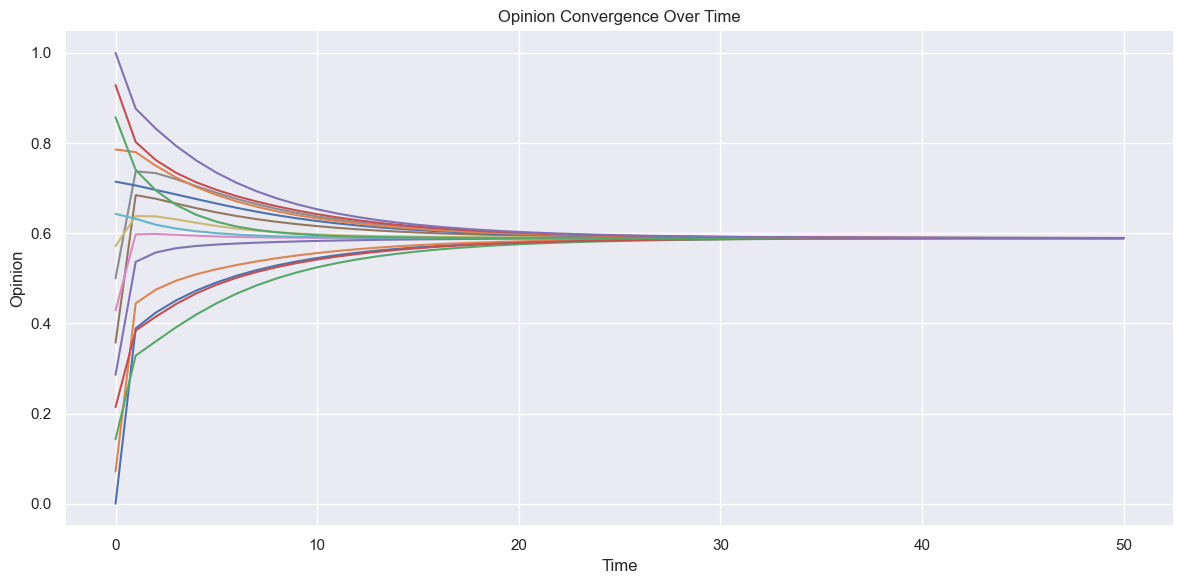

In [23]:
env = init_env()
num_steps = 50  # Total number of steps in the simulation

# Parameters
Q = 15  # Total budget (units of max_u)
step_duration = 0.5 * num_steps  # Total duration over multiple steps
sampling_time = 0.5


# Determine the control action using the total budget (units of max_u)
optimal_action, remaining_budget, controlled_agents = optimal_control_action(env, Q)

# Run the campaign with sampling
opinions_over_time, time_points = run_campaign_with_sampling(
    env,
    action=optimal_action,
    step_duration=step_duration,
    sampling_time=sampling_time,
)

# Compute errors
overall_error = compute_average_error(opinions_over_time, env.desired_opinion)
final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

print(f"Broadcast Strategy with Sampling - Overall Error: {overall_error}")
print(f"Final Error: {final_error}")
plot_opinions_over_time(opinions_over_time)

### Correct DP

In [24]:
# Initialize environment
env = init_env()

# Parameters
M = 4  # Number of campaigns
TB = 15  # Total budget
ubar = env.max_u

# Run dynamic programming
V, B, order, order0 = dynamic_programming_multiplicative(env, M, TB)

# Forward propagation to compute optimal budget allocation and final cost
BETA, U, X, final_cost = forward_propagation_multiplicative(env, V, B, order, order0, M, TB)

# Print results
print("Optimal Budget Allocation (BETA):", BETA)
print("Final Cost:", final_cost)

DPMULT step 3
DPMULT step 2
DPMULT step 1
Optimal Budget Allocation (BETA): [4 2 2 7]
Final Cost: 0.34572532971055014


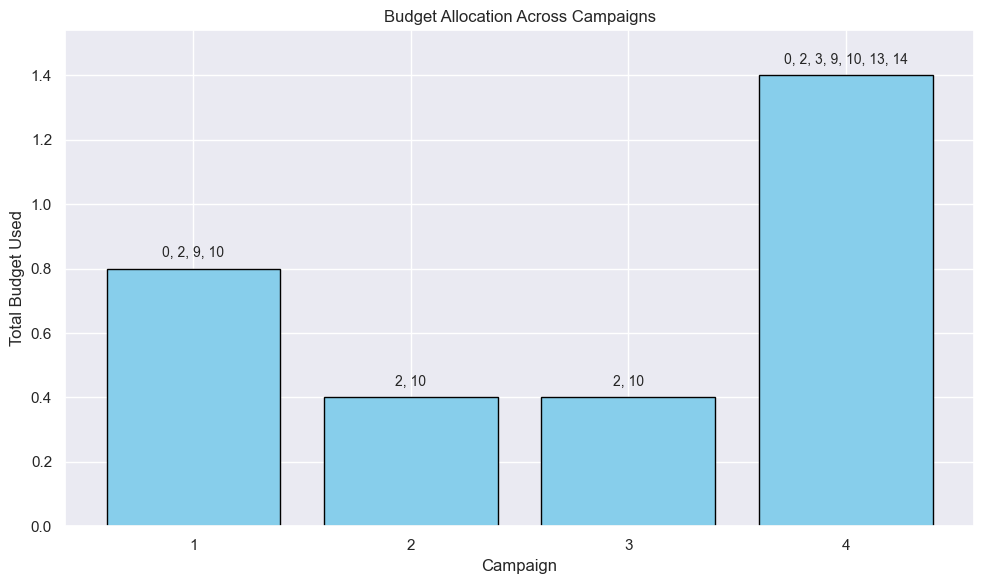

In [37]:
plot_campaign_budgets_with_order(BETA, order, order0, ubar)

Dynamic Programming Strategy - Overall Error: 0.4041578824584153
Final Error: 0.34572493545025884
[array([0, 1, 2, 3], dtype=int64), array([ 2, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13, 14], dtype=int64)]


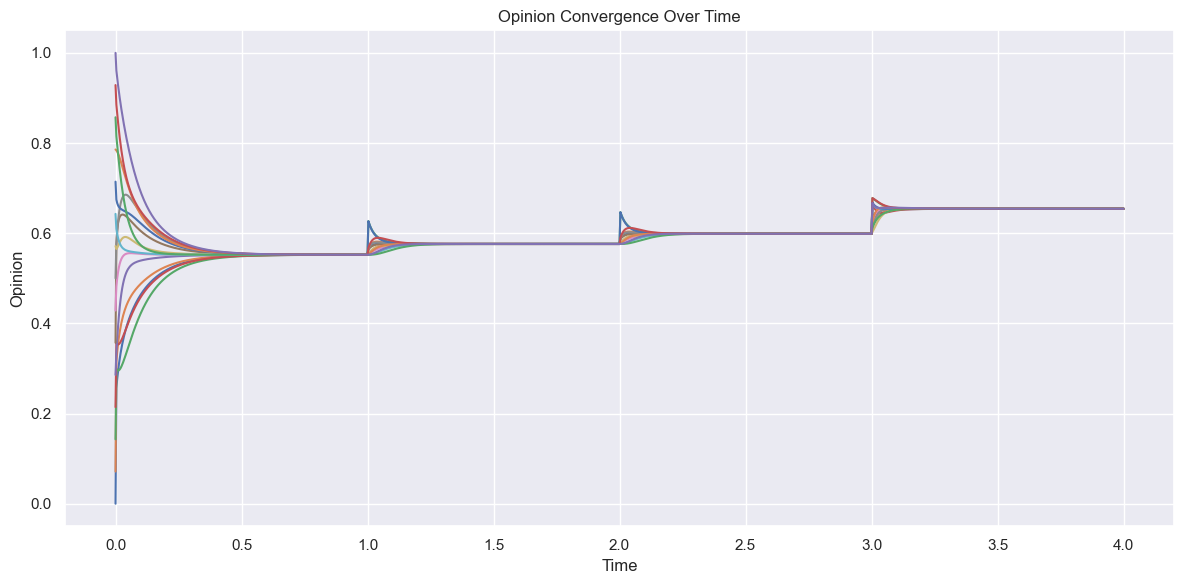

In [38]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 30
sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        BETA,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

### Wrong DP

In [25]:
import numpy as np
from algos import dynamic_programming_with_grid, forward_propagation_with_grid

# Initialize environment
env = init_env()

# Parameters
M = 4  # Number of campaigns
TB = 15  # Total budget
nx = 100  # Number of grid points
ubar = env.max_u

# Run dynamic programming
V, order, order0 = dynamic_programming_with_grid(env, M, TB, nx=nx)

# Forward propagation to compute optimal budget allocation and final cost
optimal_budget_allocation, U, X, final_cost = forward_propagation_with_grid(
    env, V, order, order0, M, TB, nx=nx
)

# Print results
print("Optimal Budget Allocation:", optimal_budget_allocation)
print("Final Cost:", final_cost)

DP step 3
DP step 2
DP step 1
Optimal Budget Allocation: [5 2 6 2]
Final Cost: 0.3499937457295831


In [26]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution(
        optimal_budget_allocation, env, M, step_duration
    )
)


final_opinion_error

0.3467026485114957

In [27]:
final_opinion_error, total_cost, costs, X = (
    compute_expected_value_for_budget_distribution([4, 2, 2, 7], env, M, step_duration)
)

final_opinion_error

0.3457234617119038

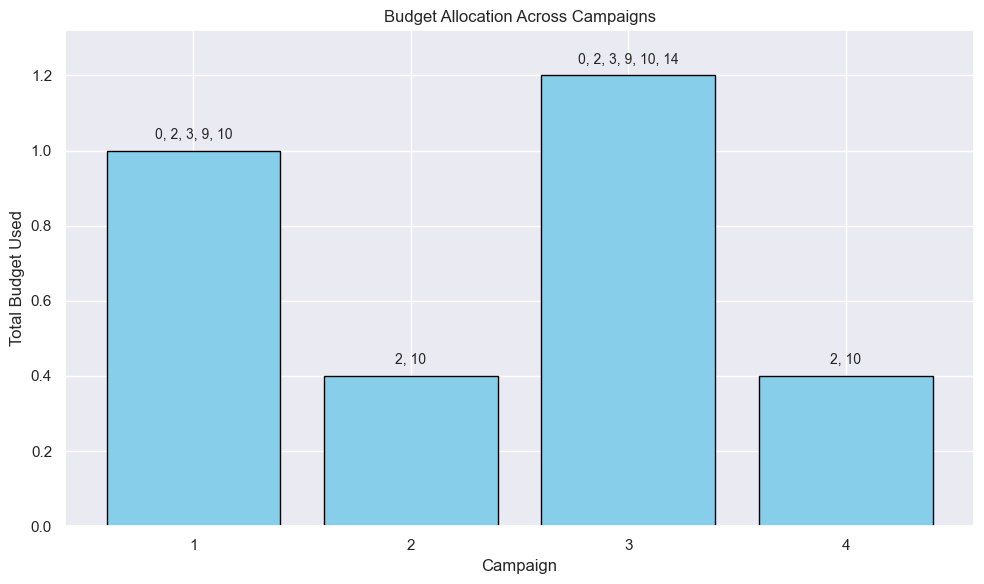

In [28]:
plot_campaign_budgets_with_order(optimal_budget_allocation, order, order0, ubar)

Dynamic Programming Strategy - Overall Error: 0.39220907286682305
Final Error: 0.34670405785587366
[array([ 0,  1,  2,  3, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13], dtype=int64), array([ 2, 10], dtype=int64)]


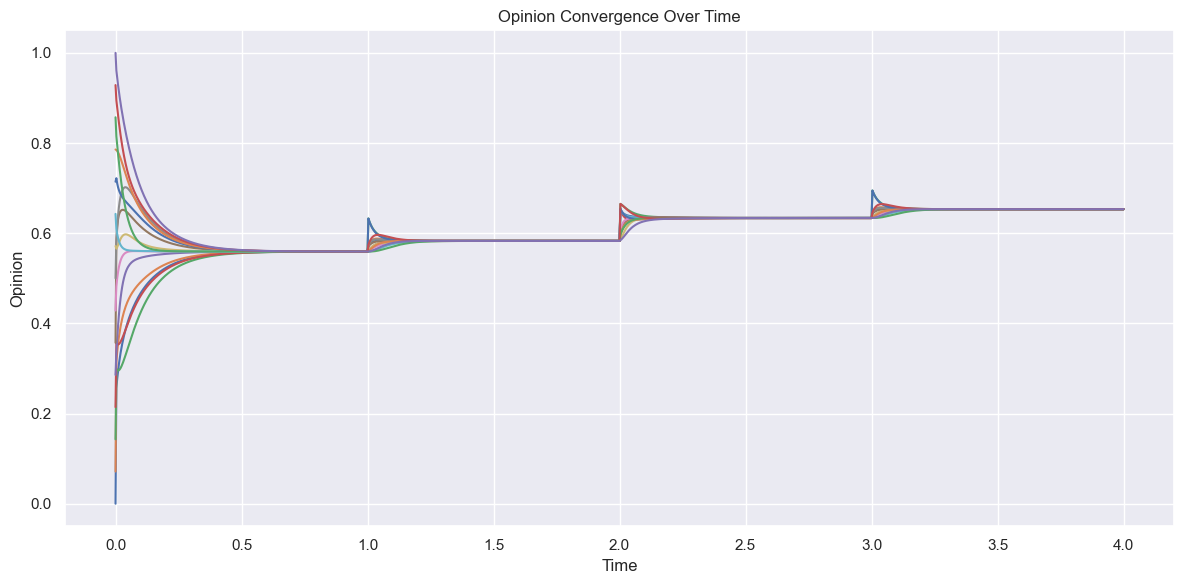

In [29]:
from algos import normalize_campaign_time, run_dynamic_programming_campaigns

env = init_env()

step_duration = 30
sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        optimal_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

Dynamic Programming Strategy - Overall Error: 0.4041578824584153
Final Error: 0.34572493545025884
[array([0, 1, 2, 3], dtype=int64), array([ 2, 10], dtype=int64), array([ 2, 10], dtype=int64), array([ 0,  2,  3,  9, 10, 13, 14], dtype=int64)]


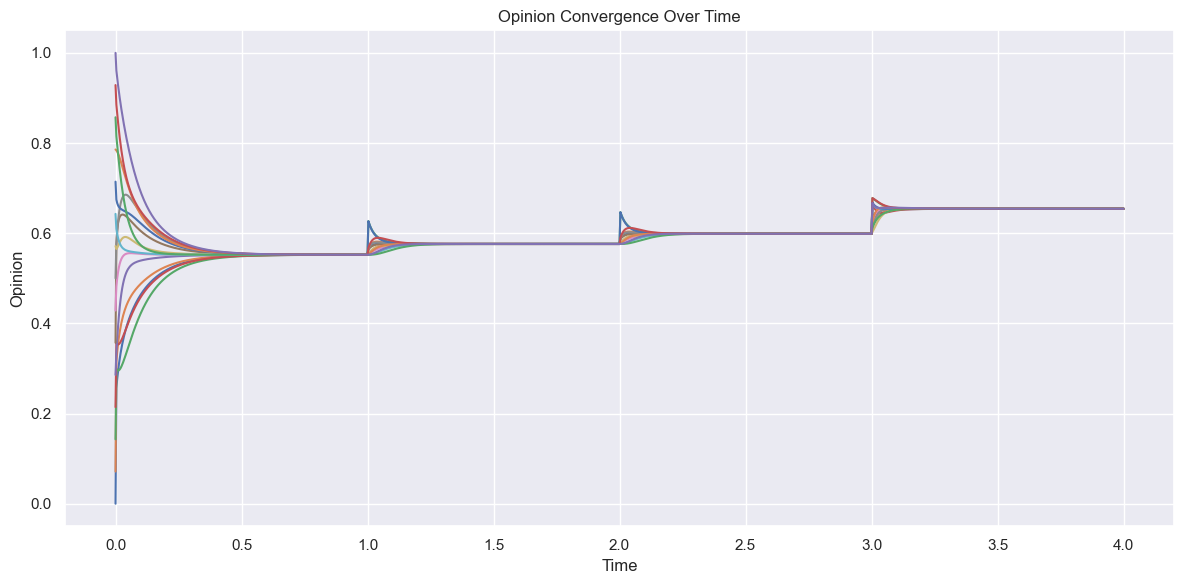

In [30]:
# from algos import run_dynamic_programming_campaigns

handmade_budget_allocation = [4, 2, 2, 7]

env = init_env()

step_duration = 30
sampling_time = 0.1
final_campaign_step_duration = 30  # Longer duration for the final campaign
final_campaign_sampling_time = sampling_time

# Run the campaigns using the optimal budget allocations
opinions_over_time_dp, time_points_dp, nodes_controlled_simulation = (
    run_dynamic_programming_campaigns(
        env,
        handmade_budget_allocation,
        step_duration,
        sampling_time,
        final_campaign_step_duration=final_campaign_step_duration,
        final_campaign_sampling_time=final_campaign_sampling_time,
    )
)

# Compute errors
overall_error_dp = compute_average_error(opinions_over_time_dp, env.desired_opinion)
final_error_dp = compute_final_average_error(opinions_over_time_dp, env.desired_opinion)

print(f"Dynamic Programming Strategy - Overall Error: {overall_error_dp}")
print(f"Final Error: {final_error_dp}")

# Compute campaign durations
campaign_durations = [step_duration] * (M - 1) + [final_campaign_step_duration]
normalized_time_points_dp = normalize_campaign_time(
    time_points_dp, campaign_durations, step_duration, final_campaign_step_duration
)

print(nodes_controlled_simulation)

# plot_opinions_over_time(opinions_over_time_dp, time_points_dp)
plot_opinions_over_time(opinions_over_time_dp, normalized_time_points_dp)

In [31]:
initial_opinions = np.linspace(0, 1, 15)
# initial_opinions = (np.mod(np.arange(0, 0.1 * num_nodes, 0.1), 0.9)) + 0.1
eigv = env.centralities
xd = 1

order = np.argsort(eigv)[::-1]  # Descending order of centralities
score0 = eigv * np.abs(initial_opinions - xd)
order0 = np.argsort(score0)[::-1]

print(order0)
print(order)

[ 2  0  3  1 10  6  9  4 11  5  7  8 13 12 14]
[ 2 10  9  0  3 14 13 11  6  1  4  8 12  7  5]


In [32]:
# initial_opinions = np.linspace(0, 1, 15)
initial_opinions = (np.mod(np.arange(0, 0.1 * 15, 0.1), 0.9)) + 0.1
eigv = env.centralities
xd = 1

order = np.argsort(eigv)[::-1]  # Descending order of centralities
score0 = eigv * np.abs(initial_opinions - xd)
order0 = np.argsort(score0)[::-1]

print(order0)
print(order)

[10  2  9  0  3  1 11 13 14  6  4 12  5  7  8]
[ 2 10  9  0  3 14 13 11  6  1  4  8 12  7  5]


In [35]:
# ### Brute force search

# from itertools import product
# from algos import run_dynamic_programming_campaigns, compute_average_error, compute_final_average_error
# from viz import plot_opinions_over_time
# from tqdm import tqdm

# # Define parameters
# total_budget = 15
# num_campaigns = 4  # Number of campaigns
# step_duration = 30
# final_campaign_step_duration = 30  # Longer duration for the final campaign
# sampling_time = 0.1
# final_campaign_sampling_time = 0.1

# # Initialize environment
# env = init_env()

# # Function to generate all valid budget allocations
# def generate_valid_budget_allocations(total_budget, num_campaigns):
#     """Generate all budget combinations where the sum of budgets is <= total_budget."""
#     allocations = []
#     for allocation in product(range(total_budget + 1), repeat=num_campaigns):
#         if sum(allocation) <= total_budget:
#             allocations.append(allocation)
#     return allocations

# # Get all valid budget allocations
# valid_budget_allocations = generate_valid_budget_allocations(total_budget, num_campaigns)

# # Store all results: budget combination and corresponding final error
# results = []

# # Brute-force search over all budget allocations
# for budget_allocation in tqdm(valid_budget_allocations, desc="Running Campaigns"):
#     # Reset environment for each test
#     env = init_env()

#     # Run the campaigns using the current budget allocation
#     opinions_over_time, time_points, nodes_controlled_simulation = run_dynamic_programming_campaigns(
#         env,
#         budget_allocation,
#         step_duration,
#         sampling_time,
#         final_campaign_step_duration=final_campaign_step_duration,
#         final_campaign_sampling_time=final_campaign_sampling_time,
#     )

#     # Compute final error
#     final_error = compute_final_average_error(opinions_over_time, env.desired_opinion)

#     # Store the result as a tuple of (budget_allocation, final_error)
#     results.append((budget_allocation, final_error))

# # Sort results by final error (ascending)
# results_sorted_by_error = sorted(results, key=lambda x: x[1])

# # Function to display top N budget combinations
# def show_top_n_budget_combinations(results_sorted, top_n=5):
#     print(f"Top {top_n} Budget Combinations by Final Error:")
#     for i in range(min(top_n, len(results_sorted))):
#         budget_allocation, final_error = results_sorted[i]
#         print(f"Rank {i+1}: Budget: {budget_allocation}, Final Error: {final_error}")

# # Display the top N budget combinations
# show_top_n_budget_combinations(results_sorted_by_error, top_n=5)

In [36]:
# results_sorted_by_error